In [31]:
# -*- coding: utf-8 -*-
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.visualization import timeline_drawer
from qiskit.visualization.timeline import draw, IQXSimple, IQXStandard

import numpy as np
import matplotlib.pyplot as plt

# For data fitting
from lmfit import Model

In [2]:
provider = IBMQ.enable_account('account-id-here')
#provider = IBMQ.load_account()

In [3]:
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

## Get gates duration
https://qiskit.org/documentation/stubs/qiskit.transpiler.InstructionDurations.get.html
https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.

In [5]:
# Get duration of instructions

dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",0)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",3)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",0)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",1)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",1)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",1)
Measurement_duration3 = transpiler.InstructionDurations.from_backend(backend).get("measure",3)

CNOT_durations = [] # Will be in dt units
for pair in backend.configuration().coupling_map:
    CNOT_pair_duration = transpiler.InstructionDurations.from_backend(backend).get("cx",pair)
    CNOT_durations.append([str(pair),CNOT_pair_duration])
CNOT_durations = dict(CNOT_durations)

tau_cnot01 = CNOT_durations["[0, 1]"]
tau_cnot10 = CNOT_durations["[1, 0]"]
tau_cnot34 = CNOT_durations["[3, 4]"]
tau_cnot43 = CNOT_durations["[4, 3]"]
tau_cnot13 = CNOT_durations["[1, 3]"]

## Define the circuit creation functions

In [9]:
def get_transpiled_circuit(num_blocks, 
                           backend, 
                           X_duration, 
                           Y_duration,
                           initial_state=0, 
                           DD_wait=True, 
                           even=True, 
                           qubit=0):

    tau_block = 2*(X_duration+Y_duration) # Time duration of a XYXY block.
    tau_wait  = num_blocks*tau_block      # Time duration of the wait part.

    # Create the registers and the circuit.
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Data/preparation gate.
    if initial_state == 1:
        circuit.x(qubit)
    elif initial_state == "+":
        circuit.h(qubit)
    elif initial_state == "-":
        circuit.x(qubit)
        circuit.h(qubit)
    
    
    wait_duration = 0
    if DD_wait == True: # Apply dynamical decoupling during the waiting part.
        wait_duration = tau_wait*dt_in_s*1e6
        for i in range(num_blocks): # Even number of pairs case.
            circuit.x(qubit)
            circuit.y(qubit)
            circuit.x(qubit)
            circuit.y(qubit)
        if even == False: # Odd number of pairs case.
            wait_duration += (X_duration + Y_duration)*dt_in_s*1e6
            circuit.x(qubit)
            circuit.y(qubit)
            
    elif DD_wait == False: # Do nothing during the waiting part.
        wait_duration = tau_wait*dt_in_s*1e6
        for i in range(num_blocks):
            circuit.id(qubit) # The number of I gates is set to fit the duration of the X and Y gates.
            circuit.id(qubit)
            circuit.id(qubit)
            circuit.id(qubit)
            circuit.id(qubit)
            circuit.id(qubit)
        if even == False:
            circuit.id(qubit)
            circuit.id(qubit)
            circuit.id(qubit)

    # Inverse of the data/preparation gate.
    if initial_state == 1:
        circuit.x(qubit)
    elif initial_state == "+":
        circuit.h(qubit)
    elif initial_state == "-":
        circuit.h(qubit)
        circuit.x(qubit)
        
    # Measurement.
    circuit.measure(qubit,0)
    
    # Transpile the circuit.
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return tcircuit, wait_duration

**Circuit building settings.**

In [10]:
# Parameters for building the circuits

max_time = 15 # In us
num_steps = 15
wait_times = np.linspace(0, max_time, num_steps) # In us.
#print(wait_times)
num_blocks_array = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # Number of blocks necessary to fit the wait times.
#print(num_blocks_array, num_steps==len(num_blocks_array))

shots = 2**13  # 8192
#print(shots)

initial_states = [0, 1, "+", "-"]
repetitions = 10
number_of_sequences = 3 # Even XY, Odd XY and free evolution (I only).

reshape_dims = (len(initial_states), repetitions, number_of_sequences, num_steps) # Dimensions for reshaping the results and making the data more manageable.
#print(reshape_dims)
#print("Total number of circuits:", np.prod(reshape_dims))

## Build the circuits

In [24]:
all_wait_times = []
all_counts = []
all_transpiled_circuits = []

qubit = 0 # Set qubit 0 or 4

"""
Data format: [[[Even case, Odd case, Free evo], repetitions...] for |0>,
              [[Even case, Odd case, Free evo], repetitions...] for |1>,
              [[Even case, Odd case, Free evo], repetitions...] for |+>,
              [[Even case, Odd case, Free evo], repetitions...] for |->]
"""

for i, initial_state in enumerate(initial_states): # Prepare all the circuits.

    repetitions_counts = []
    repetitions_wait_times = []
    
    wait_times_XYXY = []
    wait_times_XYXY_odd = []
    wait_times_IIII = []
    
    transpiled_circuits_XYXY = []
    transpiled_circuits_XYXY_odd = []
    transpiled_circuits_IIII = []
    
    state_transpiled_circuits = []

    print("Initial state:", initial_state)
    print("Generating the even XY circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the Even XY circuits.

        print("\tEven XY", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, X_duration, Y_duration, 
                                                     initial_state=initial_state, DD_wait=True, even=True, qubit=qubit)
        wait_times_XYXY.append(wait_time)
        transpiled_circuits_XYXY.append(tcircuit)
    
    print("Generating the odd XY circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the Odd XY circuits.

        print("\tOdd XY", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, X_duration, Y_duration, 
                                                     initial_state=initial_state, DD_wait=True, even=False, qubit=qubit)
        wait_times_XYXY_odd.append(wait_time)
        transpiled_circuits_XYXY_odd.append(tcircuit)
        
    print("Generating the IIII circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the IIII (free evo.) circuits.

        print("\tIIII", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, X_duration, Y_duration, 
                                                     initial_state=initial_state, DD_wait=False, even=True, qubit=qubit)
        wait_times_IIII.append(wait_time)
        transpiled_circuits_IIII.append(tcircuit)

    state_transpiled_circuits.append([transpiled_circuits_XYXY, transpiled_circuits_XYXY_odd, transpiled_circuits_IIII])
    all_wait_times.append([wait_times_XYXY, wait_times_XYXY_odd, wait_times_IIII])
    
    # Flatten the transpiled circuits to send them to IBM as a single job set
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    #print("Number of circuits:", len(circuits_array_flattened))
    
    print("Building repetitions...")
    for j in range(repetitions):
        print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()
        
    print("Done!")
    
print("Finished!")

Initial state: 0
Generating the even XY circuits...
	Even XY 0 1 15
	Even XY 0 2 15
	Even XY 0 3 15
	Even XY 0 4 15
	Even XY 0 5 15
	Even XY 0 6 15
	Even XY 0 7 15
	Even XY 0 8 15
	Even XY 0 9 15
	Even XY 0 10 15
	Even XY 0 11 15
	Even XY 0 12 15
	Even XY 0 13 15
	Even XY 0 14 15
	Even XY 0 15 15
Generating the odd XY circuits...
	Odd XY 0 1 15
	Odd XY 0 2 15
	Odd XY 0 3 15
	Odd XY 0 4 15
	Odd XY 0 5 15
	Odd XY 0 6 15
	Odd XY 0 7 15
	Odd XY 0 8 15
	Odd XY 0 9 15
	Odd XY 0 10 15
	Odd XY 0 11 15
	Odd XY 0 12 15
	Odd XY 0 13 15
	Odd XY 0 14 15
	Odd XY 0 15 15
Generating the IIII circuits...
	IIII 0 1 15
	IIII 0 2 15
	IIII 0 3 15
	IIII 0 4 15
	IIII 0 5 15
	IIII 0 6 15
	IIII 0 7 15
	IIII 0 8 15
	IIII 0 9 15
	IIII 0 10 15
	IIII 0 11 15
	IIII 0 12 15
	IIII 0 13 15
	IIII 0 14 15
	IIII 0 15 15
Building repetitions...
	Repetition 0
	Repetition 1
	Repetition 2
	Repetition 3
	Repetition 4
	Repetition 5
	Repetition 6
	Repetition 7
	Repetition 8
	Repetition 9
Done!
Initial state: 1
Generating the ev

C:\Users\usuario\AppData\Local\Temp\ipykernel_21512\3786401706.py:61: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Delay', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
C:\Users\usuario\AppData\Local\Temp\ipykernel_21512\3786401706.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  circuits_array =

	Even XY 1 6 15
	Even XY 1 7 15
	Even XY 1 8 15
	Even XY 1 9 15
	Even XY 1 10 15
	Even XY 1 11 15
	Even XY 1 12 15
	Even XY 1 13 15
	Even XY 1 14 15
	Even XY 1 15 15
Generating the odd XY circuits...
	Odd XY 1 1 15
	Odd XY 1 2 15
	Odd XY 1 3 15
	Odd XY 1 4 15
	Odd XY 1 5 15
	Odd XY 1 6 15
	Odd XY 1 7 15
	Odd XY 1 8 15
	Odd XY 1 9 15
	Odd XY 1 10 15
	Odd XY 1 11 15
	Odd XY 1 12 15
	Odd XY 1 13 15
	Odd XY 1 14 15
	Odd XY 1 15 15
Generating the IIII circuits...
	IIII 1 1 15
	IIII 1 2 15
	IIII 1 3 15
	IIII 1 4 15
	IIII 1 5 15
	IIII 1 6 15
	IIII 1 7 15
	IIII 1 8 15
	IIII 1 9 15
	IIII 1 10 15
	IIII 1 11 15
	IIII 1 12 15
	IIII 1 13 15
	IIII 1 14 15
	IIII 1 15 15
Building repetitions...
	Repetition 0
	Repetition 1
	Repetition 2
	Repetition 3
	Repetition 4
	Repetition 5
	Repetition 6
	Repetition 7
	Repetition 8
	Repetition 9
Done!
Initial state: +
Generating the even XY circuits...
	Even XY 2 1 15
	Even XY 2 2 15
	Even XY 2 3 15
	Even XY 2 4 15
	Even XY 2 5 15
	Even XY 2 6 15
	Even XY 2 7 15


C:\Users\usuario\AppData\Local\Temp\ipykernel_21512\3786401706.py:61: FutureWarning: The input object of type 'XGate' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'XGate', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.


	Even XY 2 8 15
	Even XY 2 9 15
	Even XY 2 10 15
	Even XY 2 11 15
	Even XY 2 12 15
	Even XY 2 13 15
	Even XY 2 14 15
	Even XY 2 15 15
Generating the odd XY circuits...
	Odd XY 2 1 15
	Odd XY 2 2 15
	Odd XY 2 3 15
	Odd XY 2 4 15
	Odd XY 2 5 15
	Odd XY 2 6 15
	Odd XY 2 7 15
	Odd XY 2 8 15
	Odd XY 2 9 15
	Odd XY 2 10 15
	Odd XY 2 11 15
	Odd XY 2 12 15
	Odd XY 2 13 15
	Odd XY 2 14 15
	Odd XY 2 15 15
Generating the IIII circuits...
	IIII 2 1 15
	IIII 2 2 15
	IIII 2 3 15
	IIII 2 4 15
	IIII 2 5 15
	IIII 2 6 15
	IIII 2 7 15
	IIII 2 8 15
	IIII 2 9 15
	IIII 2 10 15
	IIII 2 11 15
	IIII 2 12 15
	IIII 2 13 15
	IIII 2 14 15
	IIII 2 15 15
Building repetitions...
	Repetition 0
	Repetition 1
	Repetition 2
	Repetition 3
	Repetition 4
	Repetition 5
	Repetition 6
	Repetition 7
	Repetition 8
	Repetition 9
Done!
Initial state: -
Generating the even XY circuits...
	Even XY 3 1 15
	Even XY 3 2 15
	Even XY 3 3 15
	Even XY 3 4 15
	Even XY 3 5 15
	Even XY 3 6 15


C:\Users\usuario\AppData\Local\Temp\ipykernel_21512\3786401706.py:61: FutureWarning: The input object of type 'RZGate' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'RZGate', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.


	Even XY 3 7 15
	Even XY 3 8 15
	Even XY 3 9 15
	Even XY 3 10 15
	Even XY 3 11 15
	Even XY 3 12 15
	Even XY 3 13 15
	Even XY 3 14 15
	Even XY 3 15 15
Generating the odd XY circuits...
	Odd XY 3 1 15
	Odd XY 3 2 15
	Odd XY 3 3 15
	Odd XY 3 4 15
	Odd XY 3 5 15
	Odd XY 3 6 15
	Odd XY 3 7 15
	Odd XY 3 8 15
	Odd XY 3 9 15
	Odd XY 3 10 15
	Odd XY 3 11 15
	Odd XY 3 12 15
	Odd XY 3 13 15
	Odd XY 3 14 15
	Odd XY 3 15 15
Generating the IIII circuits...
	IIII 3 1 15
	IIII 3 2 15
	IIII 3 3 15
	IIII 3 4 15
	IIII 3 5 15
	IIII 3 6 15
	IIII 3 7 15
	IIII 3 8 15
	IIII 3 9 15
	IIII 3 10 15
	IIII 3 11 15
	IIII 3 12 15
	IIII 3 13 15
	IIII 3 14 15
	IIII 3 15 15
Building repetitions...
	Repetition 0
	Repetition 1
	Repetition 2
	Repetition 3
	Repetition 4
	Repetition 5
	Repetition 6
	Repetition 7
	Repetition 8
	Repetition 9
Done!
Finished!


### Check that the circuit function builds them correctly.

In [15]:
tc, wt =  get_transpiled_circuit(1, backend, X_duration, Y_duration, 
                                 initial_state="-", DD_wait=True, even=True, qubit=qubit)

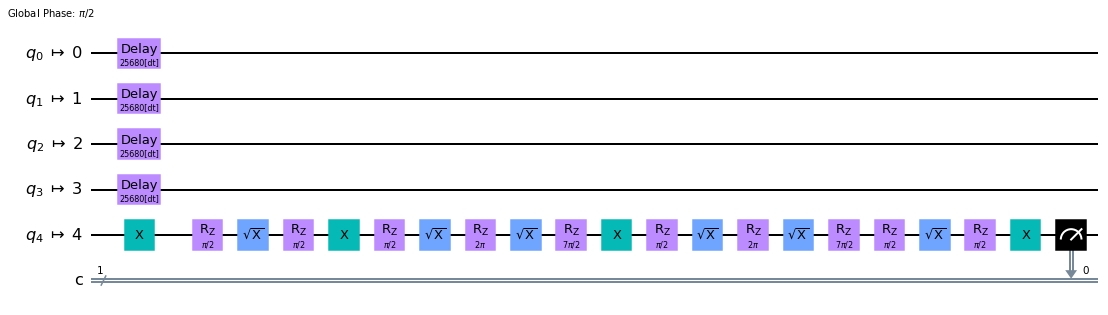

In [16]:
tc.draw("mpl", fold=-1)

### Plot a circuit schedule to look for errors.

In [32]:
# Instruction durations for the schedule plot

durations = InstructionDurations(
    [("h", 1, H_duration), 
     ("x", 0, X_duration), 
     ("x", 1, X_duration), 
     ("x", 2, X_duration), 
     ("x", 3, X_duration), 
     ("x", 4, X_duration), 
     ("z", 0, Z_duration), 
     ("z", 1, Z_duration), 
     ("z", 2, Z_duration), 
     ("z", 3, Z_duration), 
     ("z", 4, Z_duration),
     ("id", 0, I_duration),
     ("id", 1, I_duration),
     ("id", 2, I_duration),
     ("id", 3, I_duration),
     ("id", 4, I_duration),
     ("cx", [0, 1], CNOT_durations["[0, 1]"]), 
     ("cx", [1, 0], CNOT_durations["[1, 0]"]),
     ("cx", [1, 3], CNOT_durations["[1, 3]"]),
     ("cx", [3, 4], CNOT_durations["[3, 4]"]),
     ("cx", [4, 3], CNOT_durations["[4, 3]"]),
     ("reset", None, Reset_duration),
     ("measure", None, Measurement_duration)]
)

pm = PassManager([ALAPSchedule(durations)])

In [49]:
# Style for the schedule plot

# https://matplotlib.org/3.5.0/users/prev_whats_new/dflt_style_changes.html
# https://qiskit.org/documentation/stubs/qiskit.visualization.timeline_drawer.html
# https://github.com/Qiskit/qiskit-terra/pull/5063/files/5fa5898bad0a53da23c0daa61f2d99c7e822de1b#diff-4ad47bcead055d747c1ef626ff0baece4907ef6e8ee6a227c9df53459ca9ea86

my_style = {
    "formatter.latex_symbol.frame_change" : r"\,",
    'formatter.general.fig_width': 20,
    #"formatter.unicode_symbol.frame_change" : "",
    #"formatter.layer.frame_change" : 0,
    #"formatter.text_size.frame_change":0,
    #"formatter.alpha.gates":0,
    "formatter.text_size.gate_name": 14,
    "formatter.time_bucket.edge_dt": 100,
    "formatter.latex_symbol.gates":
        {
        'rz': r'\,',
        'x': r'\,',
        'sx': r'\,',
        'id': r'\,',
        'reset': r'|0\rangle',
        'measure': r'{\rm Measure}'
        },
    "formatter.color.gates":
        {
        'cx': '#6FA4FF',
        'x': '#DC143C', # Red
        'sx': '#6FA4FF', # Blue
        'reset': '#a0a0a0', # Gray
        'measure': '#a0a0a0' #'#808080',
        #'delay': '#1E90FF'
        }
}

style = IQXStandard(**my_style)

C:\Users\usuario\AppData\Local\Temp\ipykernel_21512\683128440.py:1: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Delay', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][1][2]
C:\Users\usuario\AppData\Local\Temp\ipykernel_21512\683128440.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_circuit = np.asarray(all_transpiled_circuits).re

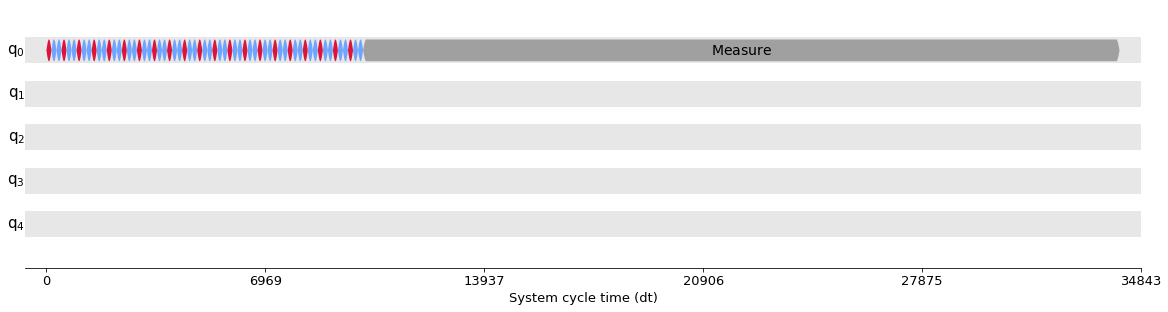

In [50]:
sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][1][2] # [state][repetition][sequence type][num_blocks index]
timeline_drawer(sample_circuit, style=style)#, show_delays=True)

## Send the job set to IBM

In [89]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='even-VS-odd-XY_errorBars-8192shots-15us-15steps-10rep-qubit4', shots=shots)
#job_monitor(job_set)

**For saving the job_set id for being able to retrieve it in the future.**

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

**For checking the job status, etc.**

In [ ]:
job_set.statuses()
#job_set.cancel()
#job_set.error_messages()

**For retrieving past job sets.**

In [23]:
jm = IBMQJobManager()
job_set = jm.retrieve_job_set("put-the-job_set-id-here", provider)

## Get the job results

In [25]:
# Get the results.
results = job_set.results()

In [26]:
# Get the counts.
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

In [27]:
# Use this if the results for some circuits do not contain |1> counts (introduce them as a dummy 0)
for i in range(len(all_counts_array)):
    if len(all_counts_array[i]) == 1:
        all_counts_array[i]["1"] = 0

## Plot the results

**For qubit 4**

0 0 <Parameter 'A', value=58.486776730632506 +/- 1.24, bounds=[-inf:inf]> <Parameter 'B', value=0.9851674398965871 +/- 0.00318, bounds=[-inf:inf]>
0 1 <Parameter 'A', value=58.82708599339832 +/- 1.26, bounds=[-inf:inf]> <Parameter 'B', value=0.984997020891612 +/- 0.00323, bounds=[-inf:inf]>
0 2 <Parameter 'A', value=10500.766470231949 +/- 2.15e+03, bounds=[-inf:inf]> <Parameter 'B', value=0.9935821529557851 +/- 0.000171, bounds=[-inf:inf]>
1 0 <Parameter 'A', value=59.1084804675964 +/- 1.68, bounds=[-inf:inf]> <Parameter 'B', value=0.9823435466079349 +/- 0.00421, bounds=[-inf:inf]>
1 1 <Parameter 'A', value=58.86388385790548 +/- 1.59, bounds=[-inf:inf]> <Parameter 'B', value=0.9827599662100743 +/- 0.00406, bounds=[-inf:inf]>
1 2 <Parameter 'A', value=35.219699918515325 +/- 0.906, bounds=[-inf:inf]> <Parameter 'B', value=0.9674957275125156 +/- 0.00641, bounds=[-inf:inf]>
2 0 <Parameter 'A', value=68.06914458615924 +/- 1.44, bounds=[-inf:inf]> <Parameter 'B', value=0.9861572265772172 +/-

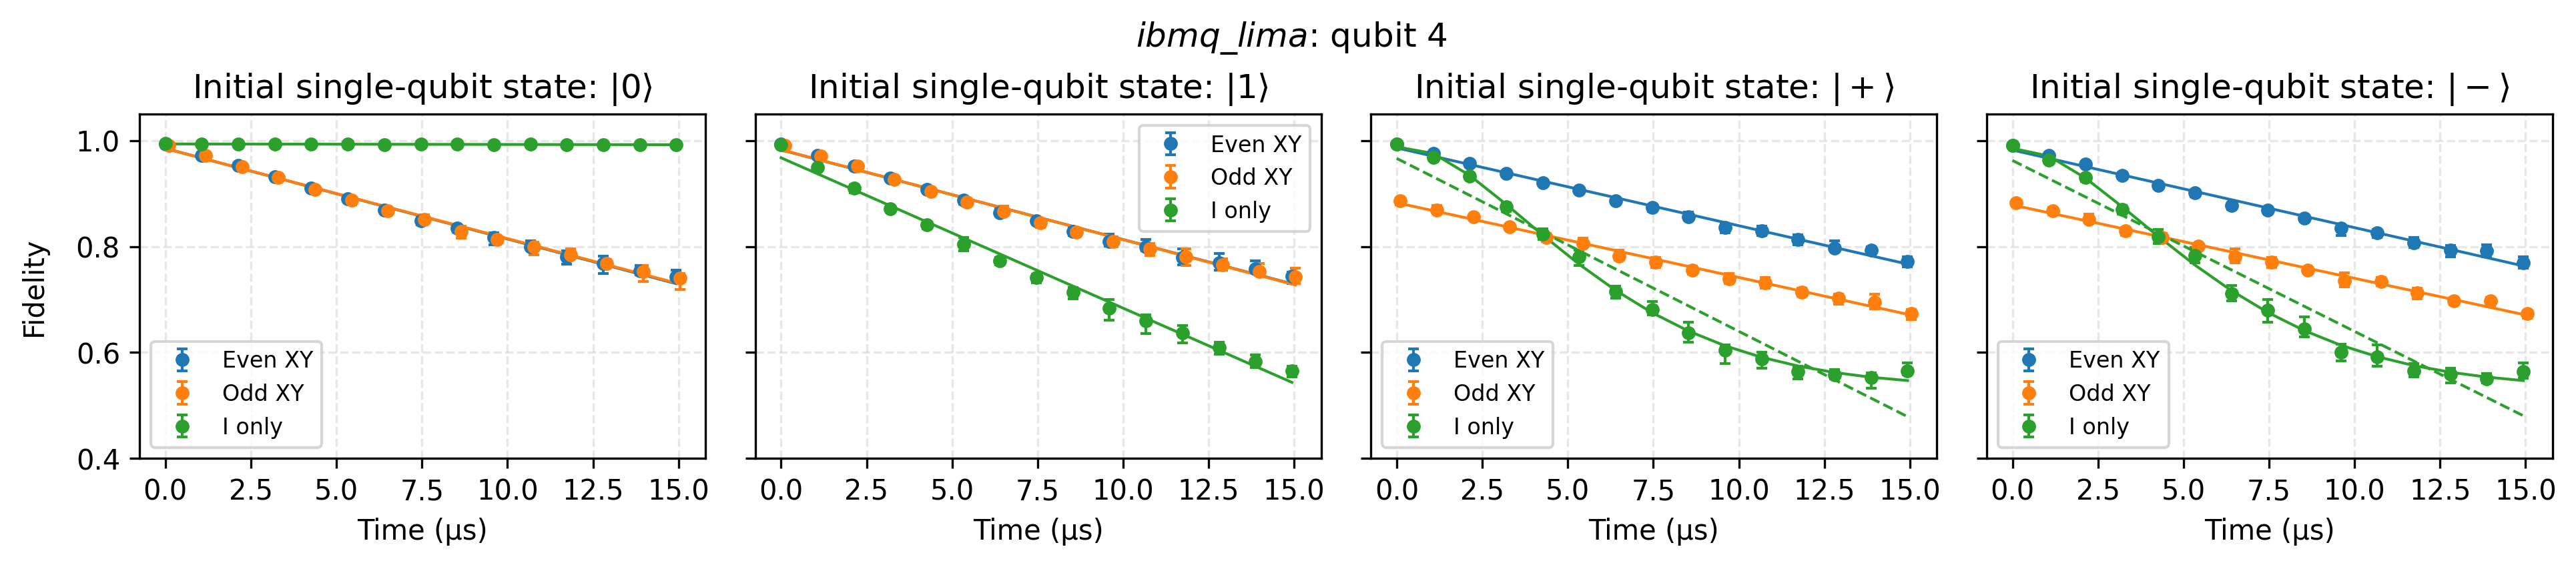

In [22]:
# On qubit 4, 0,1,+,- states -fit 

def exp_decay(x, T, A, B):
    return A*np.exp(-x/T) + B

def line_fit(x, A, B):
    return -x/A + B

def cos_ramsey(x, T, B, f, phi):
    # https://qiskit.org/documentation/experiments/tutorials/t2ramsey_characterization.html
    return np.exp(-x/T)*np.cos(2*np.pi*f*x + phi) + B

  
state_labels = ["Initial single-qubit state: $|0\\rangle$", 
                "Initial single-qubit state: $|1\\rangle$", 
                "Initial single-qubit state: $|+\\rangle$", 
                "Initial single-qubit state: $|-\\rangle$"]

wait_times = np.linspace(0, 35, 15)

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(13,3), constrained_layout=False, dpi=300)

fig.suptitle(r"$\it{ibmq\_%s}$: qubit 4" % "lima", y=0.925)
axs[0].set_ylabel("Fidelity", labelpad=10)
msize = 4 # Markersize
msize_scatter = 10 # Markersize in scatterplots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1 # Line width
elw = 1 # Errorbars line width
a = 1 # Alpha
cs = 2 # Errorbars cap size

for i, ilabel in enumerate(initial_states):
        
    axs[i].set_title(state_labels[i])
    axs[i].set_xlabel("Time (μs)")
    axs[i].set_ylim((0.4,1.05))
    axs[i].set_xticks(np.arange(0, 15+2.5, 2.5))
    
    # Get the counts for the current initial state
    counts_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[i][j][0][k]["0"] for k in range(num_steps)] for j in range(repetitions)])
    if i>1:
        counts_XYXY_odd = np.array([[all_counts_array.reshape(reshape_dims)[i][j][1][k]["1"] for k in range(num_steps)] for j in range(repetitions)])
    else:
        counts_XYXY_odd = np.array([[all_counts_array.reshape(reshape_dims)[i][j][1][k]["0"] for k in range(num_steps)] for j in range(repetitions)])
    counts_IIII = np.array([[all_counts_array.reshape(reshape_dims)[i][j][2][k]["0"] for k in range(num_steps)] for j in range(repetitions)])
    raw_counts = [counts_XYXY, counts_XYXY_odd, counts_IIII]
    
    # Get the average of the repetitions
    avg_counts_XYXY     = np.round(np.average(counts_XYXY, axis=0)).astype(int)
    avg_counts_XYXY_odd = np.round(np.average(counts_XYXY_odd, axis=0)).astype(int)
    avg_counts_IIII     = np.round(np.average(counts_IIII, axis=0)).astype(int)
    avg_counts = [avg_counts_XYXY, avg_counts_XYXY_odd, avg_counts_IIII]
    
    # Get the maximum count values of the repetitions
    max_counts_XYXY     = np.max(counts_XYXY, axis=0)
    max_counts_XYXY_odd = np.max(counts_XYXY_odd, axis=0)
    max_counts_IIII     = np.max(counts_IIII, axis=0)
    max_counts = [max_counts_XYXY, max_counts_XYXY_odd, max_counts_IIII]
    
    # Get the minimum count values of the repetitions
    min_counts_XYXY     = np.min(counts_XYXY, axis=0)
    min_counts_XYXY_odd = np.min(counts_XYXY_odd, axis=0)
    min_counts_IIII     = np.min(counts_IIII, axis=0)
    min_counts = [min_counts_XYXY, min_counts_XYXY_odd, min_counts_IIII]
    
    # Get the wait times
    t_XYXY = all_wait_times[i][0]
    t_XYXY_odd = all_wait_times[i][1]
    t_IIII = all_wait_times[i][2]

    # Get the fidelities
    fidelity_XYXY = avg_counts_XYXY/shots 
    fidelity_XYXY_odd = avg_counts_XYXY_odd/shots 
    fidelity_IIII = avg_counts_IIII/shots 

    # Calculate the limits of the error bars for each sequence
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts_XYXY/shots)
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts_XYXY/shots)
    min_err_XYXY_odd = np.abs(fidelity_XYXY_odd-min_counts_XYXY_odd/shots)
    max_err_XYXY_odd = np.abs(fidelity_XYXY_odd-max_counts_XYXY_odd/shots)
    min_err_IIII = np.abs(fidelity_IIII-min_counts_IIII/shots)
    max_err_IIII = np.abs(fidelity_IIII-max_counts_IIII/shots)
    
    # Plot the lines with the error bars
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C0",
                label="Even XY")
    axs[i].errorbar(t_XYXY_odd, fidelity_XYXY_odd, yerr=[min_err_XYXY_odd, max_err_XYXY_odd],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C1",
                label="Odd XY")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C2",
                label="I only")
    
    
    # Build the data fitting lines
    
    fidelities_state = [fidelity_XYXY, fidelity_XYXY_odd, fidelity_IIII]
    
    for k in range(3):
        state_data = fidelities_state[k]
        state_times = all_wait_times[i][k]
        
        if i>1 and k==2:  # For the |+> and |-> states add a damped-cosine fit.
            model = Model(cos_ramsey) # Damped-cosine fit
            model.set_param_hint('T', value=100, min=0)
            model.set_param_hint('B', value=0.8)
            model.set_param_hint('f', value=1)
            model.set_param_hint('phi', value=0)
            fit_result = model.fit(state_data, x=state_times) 
            print(i, k, fit_result.params["T"], fit_result.params["B"], fit_result.params["f"], fit_result.params["phi"])
            ploty = fit_result.best_fit
            axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))

            model = Model(line_fit) # Linear fit
            params = model.make_params(A=10, B=0)
            fit_result = model.fit(state_data, params, x=state_times)
            print(i, k, fit_result.params["A"], fit_result.params["B"])
            ploty = fit_result.best_fit
            axs[i].plot(state_times, ploty, linewidth=1, alpha=a, c="C"+str(k), ls="--")

        else:
            model = Model(line_fit)
            params = model.make_params(A=1, B=0)
            fit_result = model.fit(state_data, params, x=state_times)
            print(i, k, fit_result.params["A"], fit_result.params["B"])
            ploty = fit_result.best_fit
            axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))

    axs[i].legend(framealpha=0.8, fontsize=8)
    axs[i].grid(linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_oddVsEvenXY_q4_8192Shots_errorbars_10Reps_15us_15steps_12082022_fit.pdf")  

**For qubit 0**

0 0 <Parameter 'A', value=165.15980401065073 +/- 2.34, bounds=[-inf:inf]> <Parameter 'B', value=0.991090901631566 +/- 0.000754, bounds=[-inf:inf]>
0 1 <Parameter 'A', value=165.0038665291912 +/- 2.62, bounds=[-inf:inf]> <Parameter 'B', value=0.9884841773698734 +/- 0.000853, bounds=[-inf:inf]>
0 2 <Parameter 'A', value=5034.3151563665315 +/- 469, bounds=[-inf:inf]> <Parameter 'B', value=0.993271891377477 +/- 0.000163, bounds=[-inf:inf]>
1 0 <Parameter 'A', value=197.67935115868588 +/- 2.92, bounds=[-inf:inf]> <Parameter 'B', value=0.9858103434509742 +/- 0.000655, bounds=[-inf:inf]>
1 1 <Parameter 'A', value=204.46910659024127 +/- 3.99, bounds=[-inf:inf]> <Parameter 'B', value=0.987812122151813 +/- 0.000847, bounds=[-inf:inf]>
1 2 <Parameter 'A', value=89.62188040341523 +/- 0.744, bounds=[-inf:inf]> <Parameter 'B', value=0.9863891600903499 +/- 0.000813, bounds=[-inf:inf]>
2 0 <Parameter 'A', value=152.50746939071777 +/- 2.19, bounds=[-inf:inf]> <Parameter 'B', value=0.9944753011432178 +/

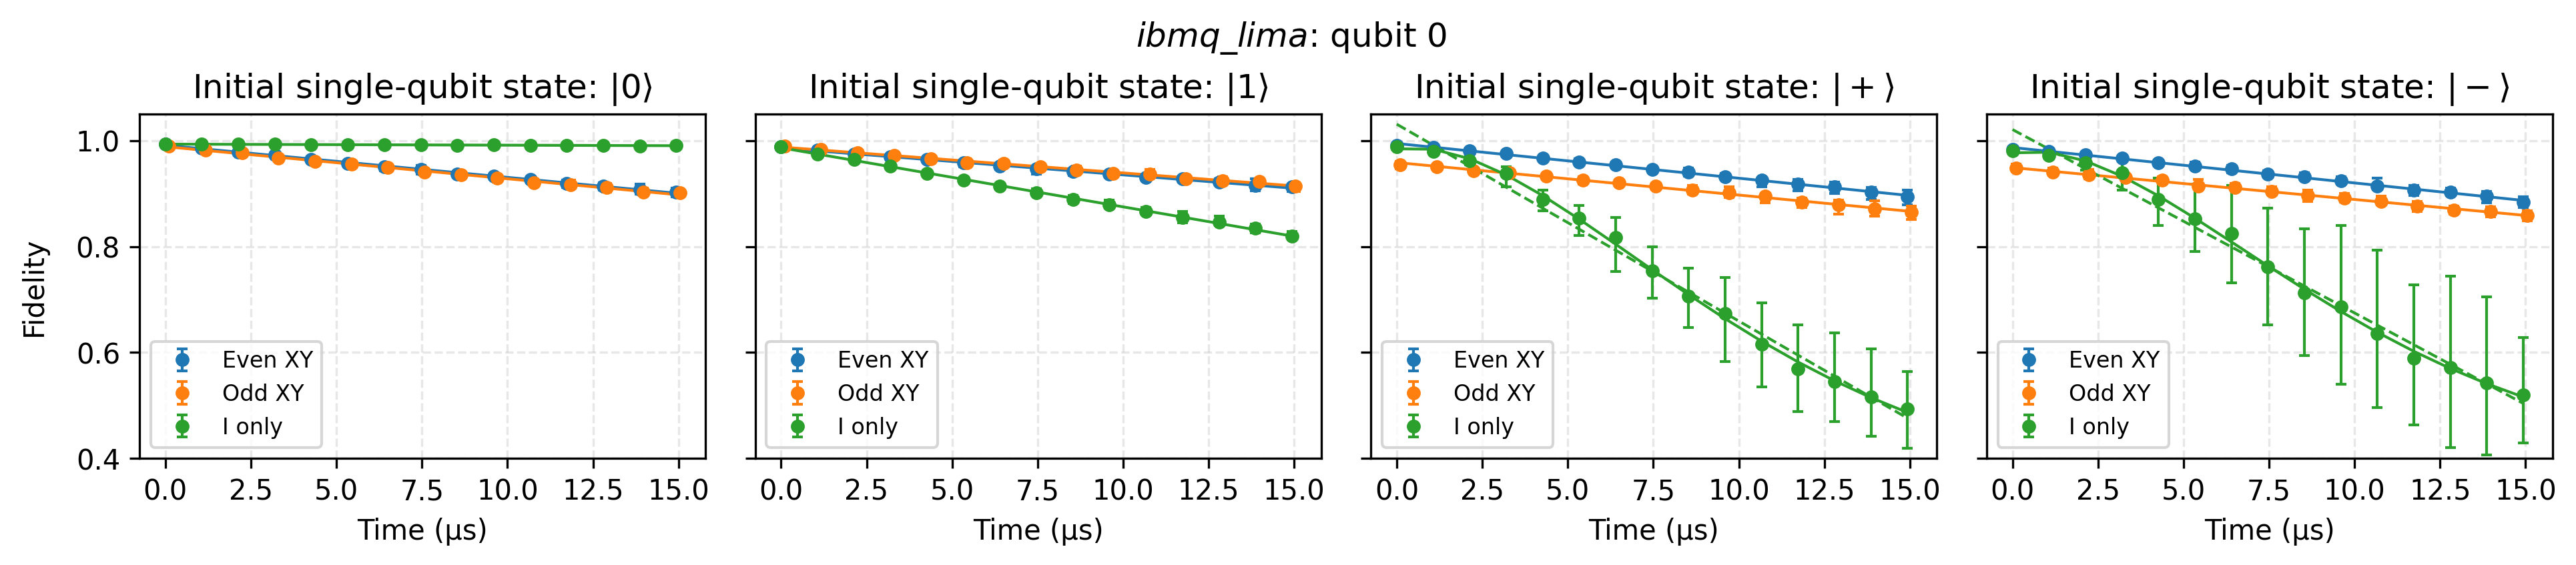

In [28]:
# On qubit 0, 0,1,+,- states -fit 

def exp_decay(x, T, A, B):
    return A*np.exp(-x/T) + B

def line_fit(x, A, B):
    return -x/A + B

def cos_ramsey(x, T, B, f, phi):
    # https://qiskit.org/documentation/experiments/tutorials/t2ramsey_characterization.html
    return np.exp(-x/T)*np.cos(2*np.pi*f*x + phi) + B

  
state_labels = ["Initial single-qubit state: $|0\\rangle$", 
                "Initial single-qubit state: $|1\\rangle$", 
                "Initial single-qubit state: $|+\\rangle$", 
                "Initial single-qubit state: $|-\\rangle$"]

wait_times = np.linspace(0, 35, 15)

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(13,3), constrained_layout=False, dpi=300)

fig.suptitle(r"$\it{ibmq\_%s}$: qubit 0" % "lima", y=0.925)
axs[0].set_ylabel("Fidelity", labelpad=10)
msize = 4 # Markersize
msize_scatter = 10 # Markersize in scatterplots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1 # Line width
elw = 1 # Errorbars line width
a = 1 # Alpha
cs = 2 # Errorbars cap size

for i, ilabel in enumerate(initial_states):
        
    axs[i].set_title(state_labels[i])
    axs[i].set_xlabel("Time (μs)")
    axs[i].set_ylim((0.4,1.05))
    axs[i].set_xticks(np.arange(0, 15+2.5, 2.5))
    
    # Get the counts for the current initial state
    counts_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[i][j][0][k]["0"] for k in range(num_steps)] for j in range(repetitions)])
    if i>1:
        counts_XYXY_odd = np.array([[all_counts_array.reshape(reshape_dims)[i][j][1][k]["1"] for k in range(num_steps)] for j in range(repetitions)])
    else:
        counts_XYXY_odd = np.array([[all_counts_array.reshape(reshape_dims)[i][j][1][k]["0"] for k in range(num_steps)] for j in range(repetitions)])
    counts_IIII = np.array([[all_counts_array.reshape(reshape_dims)[i][j][2][k]["0"] for k in range(num_steps)] for j in range(repetitions)])
    raw_counts = [counts_XYXY, counts_XYXY_odd, counts_IIII]
    
    # Get the average of the repetitions
    avg_counts_XYXY     = np.round(np.average(counts_XYXY, axis=0)).astype(int)
    avg_counts_XYXY_odd = np.round(np.average(counts_XYXY_odd, axis=0)).astype(int)
    avg_counts_IIII     = np.round(np.average(counts_IIII, axis=0)).astype(int)
    avg_counts = [avg_counts_XYXY, avg_counts_XYXY_odd, avg_counts_IIII]
    
    # Get the maximum count values of the repetitions
    max_counts_XYXY     = np.max(counts_XYXY, axis=0)
    max_counts_XYXY_odd = np.max(counts_XYXY_odd, axis=0)
    max_counts_IIII     = np.max(counts_IIII, axis=0)
    max_counts = [max_counts_XYXY, max_counts_XYXY_odd, max_counts_IIII]
    
    # Get the minimum count values of the repetitions
    min_counts_XYXY     = np.min(counts_XYXY, axis=0)
    min_counts_XYXY_odd = np.min(counts_XYXY_odd, axis=0)
    min_counts_IIII     = np.min(counts_IIII, axis=0)
    min_counts = [min_counts_XYXY, min_counts_XYXY_odd, min_counts_IIII]
    
    # Get the wait times
    t_XYXY = all_wait_times[i][0]
    t_XYXY_odd = all_wait_times[i][1]
    t_IIII = all_wait_times[i][2]

    # Get the fidelities
    fidelity_XYXY = avg_counts_XYXY/shots 
    fidelity_XYXY_odd = avg_counts_XYXY_odd/shots 
    fidelity_IIII = avg_counts_IIII/shots 

    # Calculate the limits of the error bars for each sequence
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts_XYXY/shots)
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts_XYXY/shots)
    min_err_XYXY_odd = np.abs(fidelity_XYXY_odd-min_counts_XYXY_odd/shots)
    max_err_XYXY_odd = np.abs(fidelity_XYXY_odd-max_counts_XYXY_odd/shots)
    min_err_IIII = np.abs(fidelity_IIII-min_counts_IIII/shots)
    max_err_IIII = np.abs(fidelity_IIII-max_counts_IIII/shots)
    
    # Plot the lines with the error bars
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C0",
                label="Even XY")
    axs[i].errorbar(t_XYXY_odd, fidelity_XYXY_odd, yerr=[min_err_XYXY_odd, max_err_XYXY_odd],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C1",
                label="Odd XY")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C2",
                label="I only")
    
    
    # Build the data fitting lines
    
    fidelities_state = [fidelity_XYXY, fidelity_XYXY_odd, fidelity_IIII]
    
    for k in range(3):
        state_data = fidelities_state[k]
        state_times = all_wait_times[i][k]
        
        if i>1 and k==2:  # For the |+> and |-> states add a damped-cosine fit.
            model = Model(cos_ramsey) # Damped-cosine fit
            model.set_param_hint('T', value=1200, min=0)
            model.set_param_hint('B', value=0.75)
            model.set_param_hint('f', value=1)
            model.set_param_hint('phi', value=0)
            fit_result = model.fit(state_data, x=state_times) 
            print(i, k, fit_result.params["T"], fit_result.params["B"], fit_result.params["f"], fit_result.params["phi"])
            ploty = fit_result.best_fit
            axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))

            model = Model(line_fit) # Linear fit
            params = model.make_params(A=10, B=0)
            fit_result = model.fit(state_data, params, x=state_times)
            print(i, k, fit_result.params["A"], fit_result.params["B"])
            ploty = fit_result.best_fit
            axs[i].plot(state_times, ploty, linewidth=1, alpha=a, c="C"+str(k), ls="--")

        else:
            model = Model(line_fit)
            params = model.make_params(A=1, B=0)
            fit_result = model.fit(state_data, params, x=state_times)
            print(i, k, fit_result.params["A"], fit_result.params["B"])
            ploty = fit_result.best_fit
            axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))

    axs[i].legend(framealpha=0.8, fontsize=8)
    axs[i].grid(linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_oddVsEvenXY_q0_8192Shots_errorbars_10Reps_15us_15steps_12082022_fit.pdf")  